In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from statsmodels.distributions.empirical_distribution import ECDF
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/mc_frequentist.py
%run {helper_dir}/rollup_daily_logrets.py

In [4]:
class Quantile:
    def __init__(self, q):
        self.q = q
    def __call__(self, x):
        return np.quantile(x.dropna(), self.q)

## Input

In [5]:
chain = 'Arbitrum'

In [6]:
reward_token = 'AVAX' if chain == 'Avalanche' else 'ETH'

In [7]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
fnames

{'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-07-15.csv'}

## Prep Data

In [8]:
# read data
df = (pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                 index_col='Date', parse_dates=['Date'])
        .iloc[:-1, ] # drop the last row since it may not be a full day
        .loc[:, ['glpPrice', 'glpPlusFees']]
        .rename(columns={'glpPrice':'glp_price',
                         'glpPlusFees':'glp_plusfees_price',
                        })
     )
df.tail()

glp_price  glp_plusfees_price
Date                                     
2022-07-10     0.8039              1.1100
2022-07-11     0.7854              1.0921
2022-07-12     0.7713              1.0783
2022-07-13     0.7952              1.1027
2022-07-14     0.8144              1.1223

## Frequentist Monte Carlo Simulation of Future Returns of GLP

In [9]:
# input
future_days = 120 # how many days in the future (from the last day of observation) do you want to simulate?
n_sim = 1000      # how many times/paths do you want to run? (or the number of samples to draw for each future day)
start_date = df.index[0]     # investment start date, can use a date string, for example, '2022-06-15'

In [10]:
# calc historical daily log returns of GLP
logret_his = np.log(df.glp_plusfees_price / df.glp_plusfees_price.shift(1)).dropna()
logret_his.name = 'logret'
logret_his.index.name = 'date'

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 304.044] [loc=-0.000 scale=0.017]
[distfit] >[expon     ] [0.00 sec] [RSS: 4549.72] [loc=-0.110 scale=0.110]
[distfit] >[pareto    ] [0.11 sec] [RSS: 4602] [loc=-3179790.592 scale=3179790.482]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 75.8013] [loc=-0.000 scale=0.012]
[distfit] >[t         ] [0.06 sec] [RSS: 51.9241] [loc=0.000 scale=0.012]
[distfit] >[genextreme] [0.17 sec] [RSS: 5160.88] [loc=-0.004 scale=0.120]
[distfit] >[gamma     ] [0.07 sec] [RSS: 5402.34] [loc=-0.110 scale=1.997]
[distfit] >[lognorm   ] [0.03 sec] [RSS: 423.869] [loc=-0.241 scale=0.240]
[distfit] >[beta      ] [0.12 sec] [RSS: 288.093] [loc=-12650.343 scale=12650.557]
[distfit] >[uniform   ] [0.00 sec] [RSS: 3815.63] [loc=-0.110 scale=0.192]
[distfit] >[loggamma  ] [0.03 sec] [RSS: 274.672] [loc=-0.297 scale=0.090]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


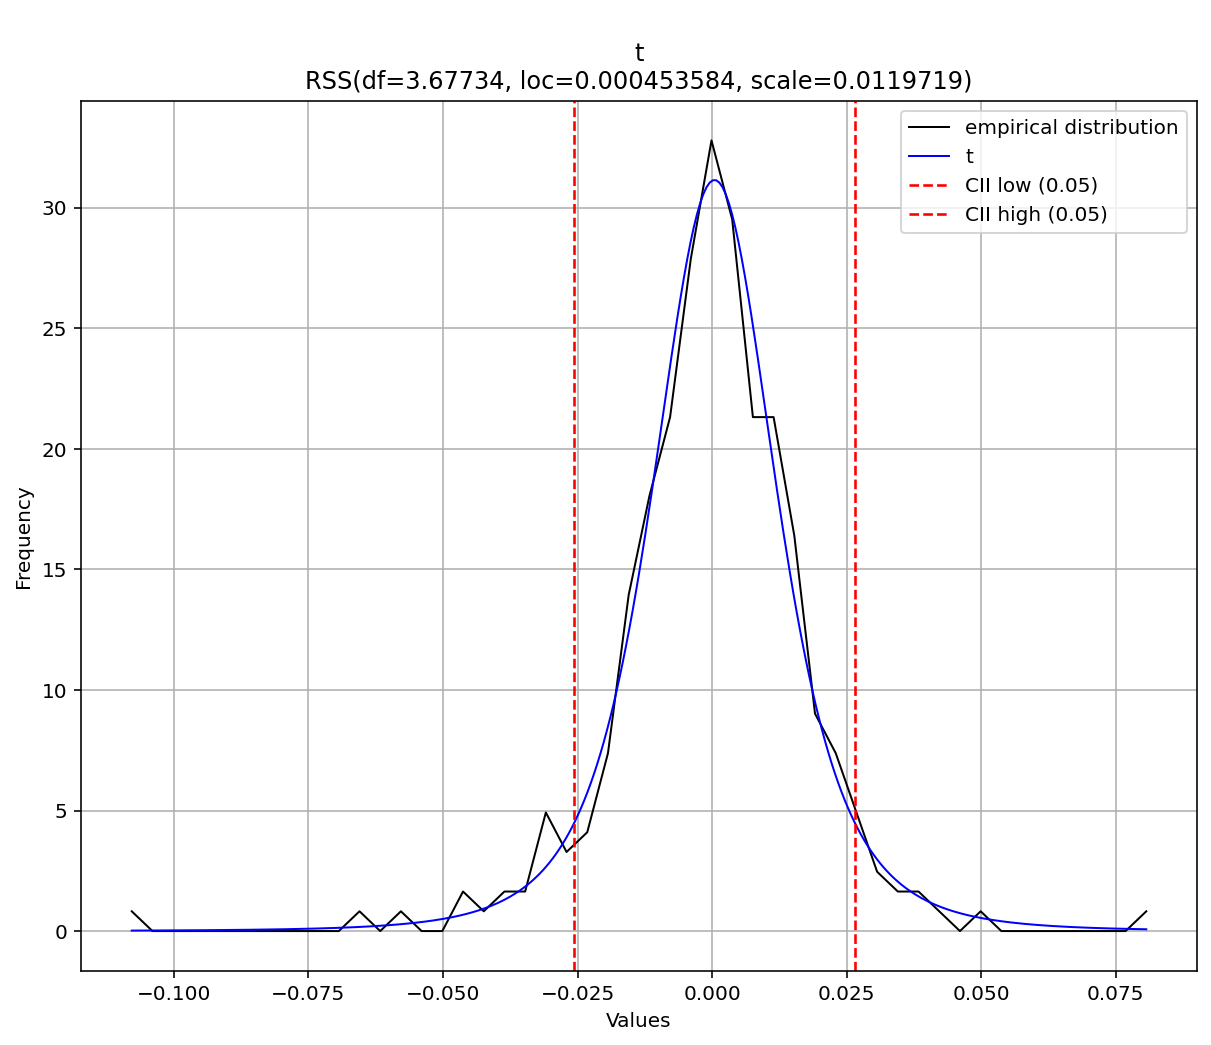

In [11]:
df_fut = mc_frequentist(logret_his, n_fut=future_days, n_iter=n_sim, show_plot=True)

In [12]:
# give meaning to the index of future log returns frame
df_fut.index = logret_his.index[-1] + pd.to_timedelta(df_fut.index.values+1, 'd')
df_fut.head()

iter1   iter2   iter3   iter4  iter5   iter6   iter7  ...  \
2022-07-15 -0.0092 -0.0011 -0.0045 -0.0012 0.0137  0.0006 -0.0080  ...   
2022-07-16 -0.0005 -0.0093 -0.0057 -0.0240 0.0044 -0.0667  0.0103  ...   
2022-07-17 -0.0230  0.0056 -0.0262 -0.0008 0.0410  0.0051  0.0086  ...   
2022-07-18 -0.0364 -0.0232 -0.0029  0.0243 0.0160  0.0240 -0.0209  ...   
2022-07-19  0.0087 -0.0102  0.0026 -0.0701 0.0142  0.0116  0.0007  ...   

            iter994  iter995  iter996  iter997  iter998  iter999  iter1000  
2022-07-15  -0.0089  -0.0197  -0.0075   0.0000  -0.0028   0.0012    0.0240  
2022-07-16  -0.0052   0.0359  -0.0136  -0.0062   0.0103   0.0083    0.0065  
2022-07-17  -0.0012   0.0132   0.0207  -0.0235  -0.0072   0.0150   -0.0198  
2022-07-18   0.0057  -0.0111   0.0095  -0.0029  -0.0021  -0.0360   -0.0019  
2022-07-19   0.0161  -0.0147  -0.0131  -0.0104   0.0052   0.0017    0.0179  

[5 rows x 1000 columns]

In [13]:
# change to long format
logret_fut = df_fut.stack()
# name the series and the levels of its index for ease of downstream process
logret_fut.name = logret_his.name
logret_fut.index.names = ['date', 'iter_no']
logret_fut

date        iter_no 
2022-07-15  iter1      -0.0092
            iter2      -0.0011
            iter3      -0.0045
            iter4      -0.0012
            iter5       0.0137
                         ...  
2022-11-11  iter996     0.0282
            iter997     0.0074
            iter998    -0.0018
            iter999     0.0118
            iter1000    0.0063
Name: logret, Length: 120000, dtype: float64

In [14]:
# give multilevel index to logret_his to be consistent with logret_fut and because
# rollup_daily_logrets() downstream expects such a multilevel index.
# since there are no runs of simulation for historical data, we'll simply use 'iter0' for the `iter_no` level.
new_index = list(zip(logret_his.index, ['iter0']*len(logret_his)))
logret_his.index = pd.MultiIndex.from_tuples(new_index, names=(logret_his.index.name, 'iter_no'))
logret_his

date        iter_no
2021-09-01  iter0      0.0826
2021-09-02  iter0     -0.0031
2021-09-03  iter0      0.0149
2021-09-04  iter0      0.0013
2021-09-05  iter0      0.0093
                        ...  
2022-07-10  iter0     -0.0122
2022-07-11  iter0     -0.0162
2022-07-12  iter0     -0.0127
2022-07-13  iter0      0.0224
2022-07-14  iter0      0.0176
Name: logret, Length: 317, dtype: float64

In [15]:
last_day = logret_his.index.get_level_values('date')[-1]
assert pd.to_datetime(start_date) <= last_day # can't start after the last day of available historical returns

# select historical daily log returns after investment start data
print("Investment started on", start_date, '\n')
chosen_logret_his = logret_his.loc[pd.to_datetime(start_date) + pd.Timedelta(days=1):]
print(chosen_logret_his.head())

Investment started on 2021-08-31 00:00:00 

date        iter_no
2021-09-01  iter0      0.0826
2021-09-02  iter0     -0.0031
2021-09-03  iter0      0.0149
2021-09-04  iter0      0.0013
2021-09-05  iter0      0.0093
Name: logret, dtype: float64


In [16]:
# roll up to weekly and monthly levels
dd_his = rollup_daily_logrets(chosen_logret_his)
dd_fut = rollup_daily_logrets(logret_fut)

## The Growth Paths of $10,000 in GLP

In [17]:
# user inputs
init_investment = 10_000 # dollars
time_freq = 'daily' # 'daily', 'weekly', or 'monthly'

In [18]:
# choose data based on user input
logrets_his = dd_his[time_freq]
logrets_fut = dd_fut[time_freq]

if time_freq == 'daily':
    time_freq_col = 'date'
elif time_freq == 'weekly':
    time_freq_col = 'week'    
else: # runs monthly by default
    time_freq_col = 'month'

In [19]:
# calc value of investment at each past time index
values_his = init_investment * logrets_his.cumsum().apply(np.exp)
values_his.name = 'value'
values_his = values_his.to_frame()
values_his

value
iter_no date                  
iter0   2021-09-01 10,861.1156
        2021-09-02 10,827.2035
        2021-09-03 10,989.3746
        2021-09-04 11,004.1827
        2021-09-05 11,107.0650
...                        ...
        2022-07-10  9,299.8205
        2022-07-11  9,150.0450
        2022-07-12  9,034.3388
        2022-07-13  9,238.8084
        2022-07-14  9,403.0884

[317 rows x 1 columns]

In [20]:
# calc value of investment at each future time index
value_now = values_his.value[-1]
values_fut = (
    logrets_fut.reset_index()
        .rename(columns={'level_0':'iter_no'})
        .set_index(['iter_no', time_freq_col])
        .sort_index()
        .groupby('iter_no')
        .logret.cumsum().apply(np.exp)
    ) * value_now
values_fut.name = 'value'
values_fut = values_fut.to_frame()
values_fut

value
iter_no date                  
iter1   2022-07-15  9,316.7754
        2022-07-16  9,312.3444
        2022-07-17  9,100.5451
        2022-07-18  8,775.2692
        2022-07-19  8,852.1196
...                        ...
iter999 2022-11-07 11,699.5410
        2022-11-08 11,991.9476
        2022-11-09 11,893.5066
        2022-11-10 12,102.7509
        2022-11-11 12,245.8210

[120000 rows x 1 columns]

In [21]:
# create a row of data for initial investment 
time_delta_val = pd.Timedelta(days=1) if time_freq == 'daily' else 1 
t0 = values_his.index.get_level_values(time_freq_col)[0] - time_delta_val 
# print(t0)
idx = pd.MultiIndex.from_arrays([['iter0'], [t0]], names=('iter_no', time_freq_col)) 
value_genesis = pd.DataFrame({'value': init_investment}, index=idx)
value_genesis

value
iter_no date             
iter0   2021-08-31  10000

In [22]:
# stack 
value_growth_paths = pd.concat([value_genesis, values_his, values_fut]) 
value_growth_paths

value
iter_no date                  
iter0   2021-08-31 10,000.0000
        2021-09-01 10,861.1156
        2021-09-02 10,827.2035
        2021-09-03 10,989.3746
        2021-09-04 11,004.1827
...                        ...
iter999 2022-11-07 11,699.5410
        2022-11-08 11,991.9476
        2022-11-09 11,893.5066
        2022-11-10 12,102.7509
        2022-11-11 12,245.8210

[120318 rows x 1 columns]

In [23]:
# reformat and prep for plot
value_growth_paths = value_growth_paths.reset_index()
value_growth_paths['group'] = np.where(value_growth_paths.iter_no == 'iter0', 'historical', 'predicted')
value_growth_paths.head()

iter_no       date       value       group
0   iter0 2021-08-31 10,000.0000  historical
1   iter0 2021-09-01 10,861.1156  historical
2   iter0 2021-09-02 10,827.2035  historical
3   iter0 2021-09-03 10,989.3746  historical
4   iter0 2021-09-04 11,004.1827  historical

In [24]:
# calc the mean and 95% CI of investment value at each time
value_means_cis = (value_growth_paths.query("iter_no != 'iter0'") # iter0 iff historical
                       .groupby(time_freq_col)
                       .agg(value_m = ('value', np.mean),
                            value_l = ('value', Quantile(.025)),
                            value_u = ('value', Quantile(.975)))
                  ).reset_index()
value_means_cis

date     value_m    value_l     value_u
0   2022-07-15  9,408.0556 9,057.8117  9,736.5770
1   2022-07-16  9,409.6356 8,919.7842  9,879.2898
2   2022-07-17  9,416.7598 8,831.4914 10,027.9707
3   2022-07-18  9,425.1974 8,775.0999 10,117.9813
4   2022-07-19  9,437.0942 8,706.9675 10,168.8223
..         ...         ...        ...         ...
115 2022-11-07 10,089.6002 6,863.6938 14,268.5197
116 2022-11-08 10,099.8713 6,848.4954 14,341.0329
117 2022-11-09 10,109.9050 6,784.4971 14,326.0564
118 2022-11-10 10,111.3923 6,760.1299 14,382.6097
119 2022-11-11 10,114.0308 6,710.1026 14,430.9984

[120 rows x 4 columns]

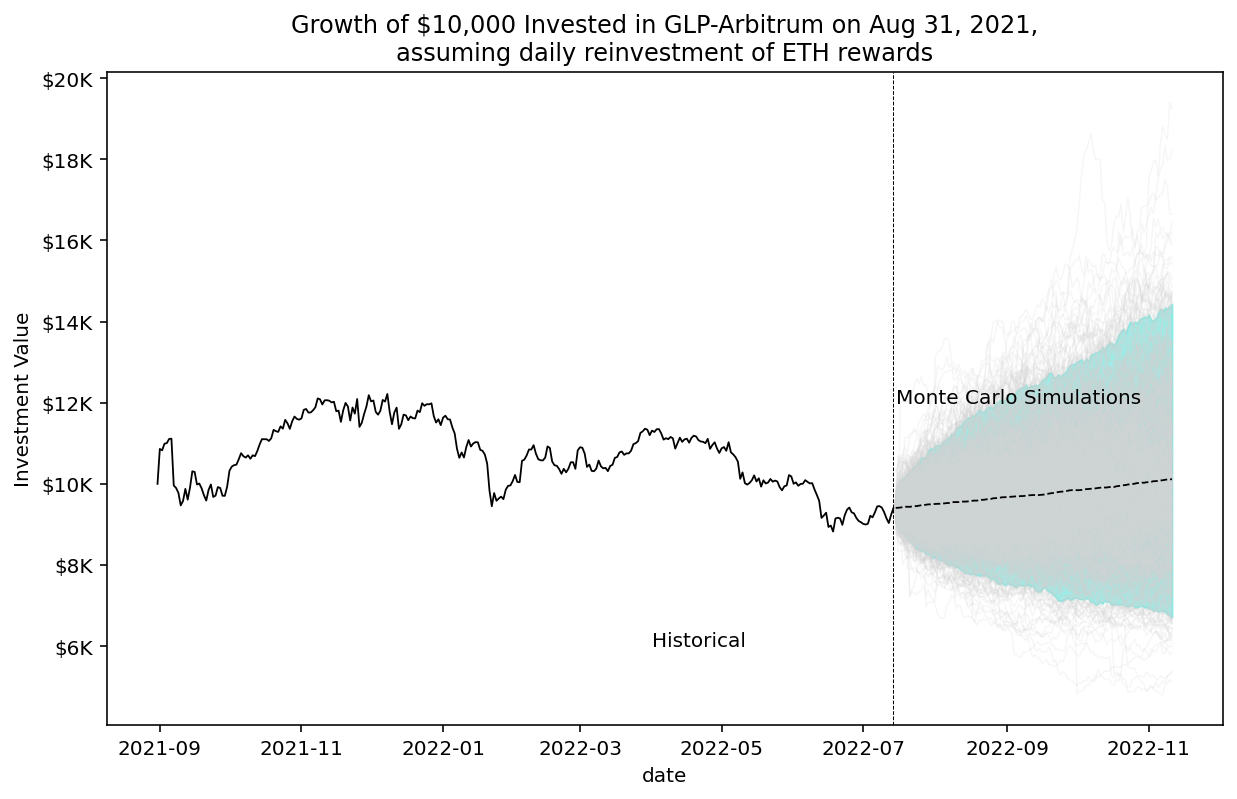

In [25]:
fig, ax = plt.subplots(1, 1)
plt.title("Growth of ${:,} Invested in GLP-{} on {},\nassuming daily reinvestment of {} rewards".format(init_investment, chain, start_date.strftime('%b %d, %Y'), reward_token))
plt.xlabel(time_freq_col)
plt.ylabel("Investment Value")

# plot historical value path
value_growth_his = value_growth_paths.query("iter_no=='iter0'")
plt.plot(time_freq_col, 'value', data=value_growth_his, color='black', alpha=1, linewidth=0.9)

# add a verticle line at the last day of historical observations; from this point onward (to the right), it's all forecasts
plt.axvline(x=last_day, linewidth=0.5, color='black', linestyle='--')

# add simulated paths for the future
for i in range(1, n_sim+1):
    da = value_growth_paths[value_growth_paths.iter_no == 'iter{}'.format(i)]
    plt.plot(time_freq_col, 'value', data=da, color='lightgray', alpha=0.2, linewidth=0.7)

# add the mean path of those simulated future paths
plt.plot(time_freq_col, 'value_m', data=value_means_cis, color='black', alpha=1, linewidth=0.9, linestyle='--')

# add the 95% confidence band of those simulated future paths
plt.fill_between(time_freq_col, y1='value_u', y2='value_l', data=value_means_cis, 
                 color="#4aeae044", linewidth=0.9, alpha=0.6)

# format y-axis to dollar currency
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

# add text
plt.text(pd.to_datetime('2022-04-01'), 6000, 'Historical')
plt.text(pd.to_datetime('2022-07-15'), 12000, 'Monte Carlo Simulations')

# save
fname = 'glp_investment_growth_since_{}_mc_vanilla.png'.format(start_date.strftime('%b %d, %Y'))
plt.savefig(os.path.join(png_dir, chain, fname), dpi=300);

## Some statistics on the simulated future returns

In [26]:
# calculate cumulative returns for each iteration
cumu_rets_fut = np.exp(logrets_fut.groupby('iter_no').cumsum()) - 1
cumu_rets_fut.name = 'cumu_ret'
cumu_rets_fut.head()

iter_no  date      
iter1    2022-07-15   -0.0092
         2022-07-16   -0.0097
         2022-07-17   -0.0322
         2022-07-18   -0.0668
         2022-07-19   -0.0586
Name: cumu_ret, dtype: float64

In [27]:
# only analyze cummulative returns in x days, where x is defined as
x_days = [7, 30, 60, 90, 120] # days
fut_start_date = cumu_rets_fut.index.get_level_values('date').min()
fut_end_dates = [fut_start_date + pd.Timedelta(days=d-1) for d in x_days]
chosen_cumu_rets_fut = cumu_rets_fut.loc[(slice(None), fut_end_dates)]
chosen_cumu_rets_fut.head() 

iter_no  date      
iter1    2022-07-21   -0.1140
         2022-08-13   -0.1595
         2022-09-12   -0.1539
         2022-10-12   -0.0916
         2022-11-11   -0.1913
Name: cumu_ret, dtype: float64

In [28]:
newindex = ['in {} days'.format(d) for d in x_days]

In [29]:
# calc expected return percentiles         
ret_percentiles = (chosen_cumu_rets_fut
                       .groupby('date')
                       .agg(percentile_10th = Quantile(.1),
                            percentile_25th = Quantile(.25),
                            percentile_50th = Quantile(.5),
                            percentile_75th = Quantile(.75),
                            percentile_90th = Quantile(.9),)
                  )
ret_percentiles.index = newindex
ret_percentiles = ret_percentiles.style.format('{:.2%}'.format)
dfi.export(ret_percentiles, os.path.join(png_dir, chain, 'glp_simret_percentiles.png'))
ret_percentiles

[0715/105754.937638:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmp3_8wi7b4/temp.png.


In [30]:
# calc return probabilities 
target_rets = np.array([0, 10, 25, 50, 100]) / 100
ret_probs = pd.concat((chosen_cumu_rets_fut.groupby('date').apply(lambda x: 1 - ECDF(x)(target_ret)) for target_ret in target_rets), axis=1)
ret_probs.index = newindex
ret_probs.columns = ["Return > {:.0%}".format(r) for r in target_rets]
ret_probs = ret_probs.style.format('{:.2%}'.format)
dfi.export(ret_probs, os.path.join(png_dir, chain, 'glp_simret_probs.png'))
ret_probs

[0715/105756.388680:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmpqgtxjkue/temp.png.
